# Recurrent Neural Network

Gerald Baulig 0780827 2019/12/24

GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we were asked to implement a Reccurent Neural Network (RNN).
We will use an RNN and sub-versions of RNN such as LSTM for naiv text generating.
An RNN is a Neural Network with a feedback loop and therewith useful to perform on sequential data.
General speaking, an RNN concartinates its own output with the input of the next (time)-frame continuously to a finite number of iterations, mostly definde by the sequence length.
A typical use case and implemented in this assignment is to predict the next symbol, based on a given sequence of symbols.

The dataset we have to process in this assignment is a section of a Shakespear's Coriolanus, but could be also any other kind of structured text. Ensure, the `data` folder has these two files:

    shakespeare_train.txt
    shakespeare_valid.txt

Furthermore, preinstall the following packages:

In [1]:
## Global imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

print("Tested Tensorflow Version: 2.0")
print("Current Tensorflow Version:", tf.__version__)

Tested Tensorflow Version: 2.0
Current Tensorflow Version: 2.0.0


## Data Preparation


In [2]:
def load_data(filename, verbose=False):
    with open(filename, 'rb') as fid:
        text = fid.read()
        pass
    np_text = np.array(list(text))
    vocab = np.unique(list(text))
    vocab_dict = {c:i for i, c in enumerate(vocab)}
    vec_text = np.array([vocab_dict[c] for c in np_text])
    if verbose:
        print("\n--- Plain Text:", len(text), "---\n", text[:100].decode('utf-8'), "...")
        print("\n--- Numpy Array:", np_text.shape, "---\n", np_text[:100], "...")
        print("\n--- Vocabular:", vocab.shape, "---\n", vocab[:10], "...")
        print("\n--- Dictionary ---\n", vocab_dict)
        print("\n--- Vectorized Text:", vec_text.shape, "---\n", vec_text[:100], "...")
    return vec_text, vocab, vocab_dict

## Run!
val, _, _ = load_data('data/shakespeare_valid.txt', True)
train, vocab, vocab_dict = load_data('data/shakespeare_train.txt')


--- Plain Text: 229972 ---
 DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The a ...

--- Numpy Array: (229972,) ---
 [ 68  85  75  69  32  79  82  83  73  78  79  58  13  10  73 102  32 109
 117 115 105  99  32  98 101  32 116 104 101  32 102 111 111 100  32 111
 102  32 108 111 118 101  44  32 112 108  97 121  32 111 110  59  13  10
  71 105 118 101  32 109 101  32 101 120  99 101 115 115  32 111 102  32
 105 116  44  32 116 104  97 116  44  32 115 117 114 102 101 105 116 105
 110 103  44  13  10  84 104 101  32  97] ...

--- Vocabular: (63,) ---
 [10 13 32 33 39 44 45 46 58 59] ...

--- Dictionary ---
 {10: 0, 13: 1, 32: 2, 33: 3, 39: 4, 44: 5, 45: 6, 46: 7, 58: 8, 59: 9, 63: 10, 65: 11, 66: 12, 67: 13, 68: 14, 69: 15, 70: 16, 71: 17, 72: 18, 73: 19, 74: 20, 75: 21, 76: 22, 77: 23, 78: 24, 79: 25, 80: 26, 81: 27, 82: 28, 83: 29, 84: 30, 85: 31, 86: 32, 87: 33, 88: 34, 89: 35, 90: 36, 97: 37, 98: 38, 99: 39, 100: 40, 101: 41, 102: 42, 103

### Create Tensorflow Datagenerators

In [3]:
def mapping(chunk):
    y = chunk[:-1]
    t = chunk[1:]
    return y, t

def create_datagenerator(data, chunk_sz, batch_sz, buffer_sz):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.batch(chunk_sz+1, drop_remainder=True)
    dataset = dataset.map(mapping)
    dataset = dataset.shuffle(buffer_sz).batch(batch_sz, drop_remainder=True)
    return dataset

## Run!
chunk_size = 100
batch_size = 64

train_set = create_datagenerator(train, chunk_size, batch_size, buffer_sz=1000)
val_set = create_datagenerator(train, chunk_size, batch_size, buffer_sz=200)

print(val_set)
for batch in val_set.take(1):
    print("\n--- Input Y: ---\n", bytes([vocab[i] for i in batch[0].numpy()[0]]).decode('utf-8'))
    print("\n--- Target T: ---\n", bytes([vocab[i] for i in batch[1].numpy()[0]]).decode('utf-8'))

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

--- Input Y: ---
 oth he,
'That I receive the general food at first,
Which you do live upon; and fit it is,
Because

--- Target T: ---
 th he,
'That I receive the general food at first,
Which you do live upon; and fit it is,
Because 


## Setup a SimpleRNN

In [6]:
def setup_rnn(inp_dim, emb_dim, units, batch_sz):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(inp_dim, emb_dim, batch_input_shape=[batch_sz, None]))
    model.add(layers.SimpleRNN(
        units,
        return_sequences=True,
        stateful=True
    ))
    model.add(layers.Dense(inp_dim))
    return model

def eval_acc(epoch, logs)
    print("Test:")
    eval = model.evaluate(x_test, y_test)
    logs['test_loss'] = eval[0]
    logs['test_acc'] = eval[1]
    print('Test loss:', eval[0], 'Test accuracy:', eval[1])

## Run!
inp_dim = vocab.size
emb_dim = 256
units = 1024
batch_size = 64

if ('model' in globals()):
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model

model = setup_rnn(inp_dim, emb_dim, units, batch_size)
model.summary()

Clean up old model!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           17408     
_________________________________________________________________
simple_rnn (SimpleRNN)       (64, None, 1024)          1311744   
_________________________________________________________________
dense (Dense)                (64, None, 68)            69700     
Total params: 1,398,852
Trainable params: 1,398,852
Non-trainable params: 0
_________________________________________________________________


## Train a SimpleRNN



In [ ]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

def loss(labels, logits):
    return sparse_categorical_crossentropy(labels, logits, from_logits=True)

def run_training(model, trainset, valset, epochs, checkpoint):
    mc = ModelCheckpoint(
        filepath=checkpoint,
        save_weights_only=True
    )
    model.compile(optimizer='adam', loss=loss)
    return model.fit(trainset, epochs=epochs, validation_data=valset, callbacks=[mc])

## Run!
epochs = 10
checkpoint = './models/rnn_{epoch}'
history = run_training(model, train_set, val_set, epochs, checkpoint)

Epoch 1/10
697/697 [==============================] - 77s 111ms/step - loss: 2.0266 - val_loss: 0.0000e+00
Epoch 2/10
697/697 [==============================] - 77s 110ms/step - loss: 1.5512 - val_loss: 1.5353
Epoch 3/10
697/697 [==============================] - 77s 110ms/step - loss: 1.4381 - val_loss: 1.4545
Epoch 4/10
697/697 [==============================] - 77s 111ms/step - loss: 1.3848 - val_loss: 1.4158
Epoch 5/10
697/697 [==============================] - 77s 111ms/step - loss: 1.3536 - val_loss: 1.3949
Epoch 6/10
697/697 [==============================] - 77s 111ms/step - loss: 1.3323 - val_loss: 1.3739
Epoch 7/10
697/697 [==============================] - 77s 111ms/step - loss: 1.3170 - val_loss: 1.3568
Epoch 8/10
697/697 [==============================] - 77s 111ms/step - loss: 1.3039 - val_loss: 1.3466
Epoch 9/10
697/697 [==============================] - 78s 112ms/step - loss: 1.2940 - val_loss: 1.3316
Epoch 10/10
 62/697 [=>............................] - ETA: 54s - los

## Plot Learning Curves

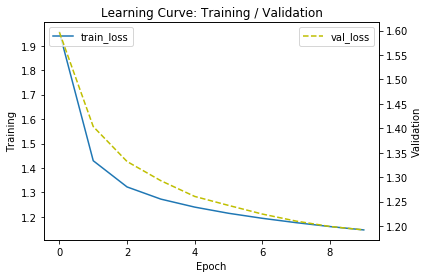

In [7]:
def plot_history(history):
    ## Plot Training Loss
    _, ax_l = plt.subplots(1)
    ax_l.plot(history.history['loss'], label='train_loss')
    ax_l.set_ylabel("Training")
    ax_l.set_xlabel("Epoch")
    ax_l.legend(loc=2)

    ## Plot Validation Loss
    ax_r = ax_l.twinx()
    ax_r.plot(history.history['val_loss'], 'y--', label='val_loss')
    ax_r.set_ylabel("Validation")
    ax_r.legend()
    
    plt.title("Learning Curve: Training / Validation")
    plt.show()

## Run!
plot_history(history)

## Restore Checkpoint

In [19]:
def restore_checkpoint(checkpoint, setup_lambda):
    model = setup_lambda()
    model.load_weights(checkpoint)
    model.build(tf.TensorShape([1, None]))
    return model

## Run!
if ('model' in globals()):
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model
    pass

model = restore_checkpoint(
    './models/rnn_10',
    lambda: setup_rnn(inp_dim, emb_dim, units, batch_sz=1)
)

model.summary()

Clean up old model!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 256)            17408     
_________________________________________________________________
gru (GRU)                    (1, None, 1024)           3938304   
_________________________________________________________________
dense (Dense)                (1, None, 68)             69700     
Total params: 4,025,412
Trainable params: 4,025,412
Non-trainable params: 0
_________________________________________________________________


## Generate Text with RNN

In [20]:
def generate_text(model, seed, vocab, vocab_dict, length=100, temp=1.0, grow=False):
    #vectorize the seed string
    bseed = bytes(seed, 'utf-8')
    vec_seed = np.array([vocab_dict[c] for c in bseed])
    vec_seed = np.expand_dims(vec_seed, 0)
    pred_ids = []
    
    model.reset_states()
    for i in range(length):
        pred = model.predict(vec_seed)
        pred = tf.squeeze(pred, 0)

        pred /= temp
        pred_id = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
        pred_ids.append(pred_id)
        if grow:
            vec_seed = tf.expand_dims(pred_ids, 0)
        else:
            vec_seed = tf.expand_dims(pred_id, 0)
        
    gen_text = seed + bytes([vocab[i] for i in pred_ids]).decode('utf-8')
    return gen_text

## Run!
text = generate_text(model, "JULIET", vocab, vocab_dict, 100, 1, False)
print(text)

JULIET:
Yes, sir?

Second Bandit:
Therefore old maid be fit, my ladvest and can your grace the scholar


## Compare Traning Progress Qualitatively


In [21]:
tf.autograph.set_verbosity(3)
tf.get_logger().setLevel('ERROR')

checkpoints = [
    './models/rnn_1',
    './models/rnn_2',
    './models/rnn_4',
    './models/rnn_6',
    './models/rnn_8',
    './models/rnn_10'
]

for checkpoint in checkpoints:
    if ('model' in globals()):
        tf.keras.backend.clear_session()
        del model
    
    model = restore_checkpoint(
        checkpoint,
        lambda: setup_rnn(inp_dim, emb_dim, units, batch_sz=1)
    )
    text = generate_text(model, "JULIET", vocab, vocab_dict, 100, 0.1)
    print("\n---Checkpoint : ", checkpoint, " ---\n", text)


---Checkpoint :  ./models/rnn_1  ---
 JULIETUS:
I am all the read and the strenger to the stand,
And the stand and with the beart of the stand

---Checkpoint :  ./models/rnn_2  ---
 JULIET:
And what shall I say the commons of the court,
And the thing the state of the streets of the boy

---Checkpoint :  ./models/rnn_4  ---
 JULIET:
Ay, and the seasons that I may discover him.

SUFFOLK:
The king and country and the seasons of

---Checkpoint :  ./models/rnn_6  ---
 JULIET:
Ay, then, the duke and the son of the state of the king.

CADE:
And then the son of God's sake

---Checkpoint :  ./models/rnn_8  ---
 JULIET:
And so they say, if thou wert a beast, and therefore let me see the law.

SIMPCOX:
All happine

---Checkpoint :  ./models/rnn_10  ---
 JULIET:
And what a thing that I will see the better?

SIMPCOX:
Alas, my lord, the law can do nothing b


# Long Short-Term Memory RNN (LSTM)

## Generate and Train the LSTM

In [ ]:
def setup_lstm(inp_dim, emb_dim, units, batch_sz):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(inp_dim, emb_dim, batch_input_shape=[batch_sz, None]))
    model.add(layers.LSTM(units))
    model.add(layers.Dense(inp_dim))
    return model

## Runt!
print("------- Setup -------")
inp_dim = vocab.size
emb_dim = 256
units = 1024
batch_size = 64

if ('model' in globals()):
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model

model = setup_lstm(inp_dim, emb_dim, units, batch_size)
model.summary()

print("------- Train -------")
epochs = 10
checkpoint = './models/lstm_{epoch}'
history = run_training(model, train_set, val_set, epochs, checkpoint)

print("------- Plot -------")
plot_history(history)

# Gated Recurrent Unit (GRU)

In [ ]:
def setup_gru(inp_dim, emb_dim, units, batch_sz):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(inp_dim, emb_dim, batch_input_shape=[batch_sz, None]))
    #model.add(layers.SimpleRNN(units))
    model.add(layers.GRU(units,
        return_sequences=True,
        stateful=True
    ))
    model.add(layers.Dense(inp_dim))
    return model

## Run!
inp_dim = vocab.size
emb_dim = 256
units = 1024
batch_size = 64

if ('model' in globals()):
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model

model = setup_gru(inp_dim, emb_dim, units, batch_size)
model.summary()